In [1]:
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import os
import natsort
from PIL import Image
from torchvision.transforms import ToPILImage
import copy

In [17]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:5000px;
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [2]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir):
        self.images_dir = images_dir
        self.image_names = natsort.natsorted(os.listdir(images_dir))     
        
    def __len__(self):
        return len(self.image_names)
                   
    def __getitem__(self, idx):
        image_loc = os.path.join(self.images_dir, self.image_names[idx])
        image = Image.open(image_loc).convert("RGB")
        return image
    
def tonp(image): # (100, 100, 3)
    return np.array(image)

def topil(array):
    return ToPILImage()(array)

def tonp2(image): # (3, 100, 100)
    return np.array(image).transpose(2, 0, 1)

def topil2(array):
    return ToPILImage()((array).transpose(1, 2, 0))

def tobw(image, threshold):
    arr = tonp2(image)
    new_arr = np.zeros_like(arr)
    new_arr[:, arr[0] + arr[1] + arr[2] <= threshold] = 255
    return topil2(new_arr)

def getpix(image, i, j):
    arr = tonp(image)
    return arr[i, j]

def putpix(image, i, j, color):
    arr = tonp(image)
    arr[i, j] = np.array(color)
    return topil(arr)

In [3]:
def mask(image, the_mask, threshold=120):
    arr = tonp2(image).astype(int)
    new_arr = copy.copy(arr)
    for i in range(1, new_arr.shape[1] - 1):
        for j in range(1, new_arr.shape[2] - 1):
            new_arr[:, i, j] = np.sum(arr[:, i - 1:i + 2, j - 1:j + 2] * the_mask)
    new_arr[new_arr <= threshold] = 0
    return topil2(new_arr.astype(np.uint8))

def conv(image, n):
    if n <= 1:
        return image
    arr = tonp2(image)
    new_arr = copy.copy(arr)
    for i in range(new_arr.shape[1] // n):
        for j in range(new_arr.shape[2] // n):
            for k in range(3):
                new_arr[k, i*n:i*n + n, j*n:j*n + n] = np.mean(arr[k, i*n:i*n + n, j*n:j*n + n])
    return topil2(new_arr)

def conv2(image, n):
    if n <= 1:
        return image
    arr = tonp2(image)
    new_arr = np.zeros((3, arr.shape[1]//n, arr.shape[2]//n), dtype=np.uint8)
    for i in range(new_arr.shape[1]):
        for j in range(new_arr.shape[2]):
            for k in range(3):
                new_arr[k, i, j] = arr[k, i*n, j*n]
    return topil2(new_arr)


def unbright(image, threshold=255, delta=30):
    arr = tonp2(image)
    brightness = arr[0].astype(int) + arr[1].astype(int) + arr[2].astype(int)
    mask = brightness >= threshold
    arr[0, mask] -= delta
    arr[1, mask] -= delta
    arr[2, mask] -= delta
    return topil2(arr)

def unbright2(image, threshold=50, delta=50):
    arr = tonp2(image)
    brightness1 = arr[0].astype(int) >= threshold
    brightness2 = arr[1].astype(int) >= threshold
    brightness3 = arr[2].astype(int) >= threshold
    mask = brightness1 * brightness2 * brightness3
    arr[0, mask] -= delta
    arr[1, mask] -= delta
    arr[2, mask] -= delta
    return topil2(arr)


def bright2(image, delta=50):
    arr = tonp2(image).astype(int)
    brightness1 = arr[0].astype(int) != 0
    brightness2 = arr[1].astype(int) != 0
    brightness3 = arr[2].astype(int) != 0
    mask = brightness1 * brightness2 * brightness3
    arr[0, mask] += delta
    arr[1, mask] += delta
    arr[2, mask] += delta
    arr[arr > 255] = 255
    return topil2(arr.astype(np.uint8))

In [4]:
def gen_loccol(image, c, threshold):
    """
    Все похожие цвета изображения в виде массива
    """
    arr = tonp2(image).astype(int)
    dist = ((arr[0] - c[0])**2 + (arr[1] - c[1])**2 + (arr[2] - c[2])**2)**0.5
    return dist <= threshold

def add_to_gr(arr, index, gr):
    """
    Добавление в группу позиций на -1-цах (есть массив: нули там, где нет объектов, -1 - там, где есть)
    """
    if arr[index[0], index[1]] == -1:
        arr[index[0], index[1]] = gr
        if index[0] > 0:
            arr = add_to_gr(arr, [index[0] - 1, index[1]], gr)
        if index[0] < arr.shape[0] - 1:
            arr = add_to_gr(arr, [index[0] + 1, index[1]], gr)
        if index[1] > 0:
            arr = add_to_gr(arr, [index[0], index[1] - 1], gr)
        if index[1] < arr.shape[1] - 1:
            arr = add_to_gr(arr, [index[0], index[1] + 1], gr)
    return arr

def make_share(array):
    """
    Распределение массива пикселей объектов по группам
    array - 0, где нет предметов, -1 - где есть
    """
    gr = 1
    while np.any(array == -1):
        first = np.where(array == -1)
        first = np.array([first[0][0], first[1][0]])
        array = add_to_gr(array, first, gr)
        gr += 1
    return array

def seg_to_image(image, array):
    """
    Перевод на изображение результатов сегментации с укороченным массивом 
    (с размеченными по группам пикселями)
    """
    img_arr = tonp(image)
    img_shape = img_arr.shape
    ix = img_shape[0] // array.shape[0]
    jx = img_shape[1] // array.shape[1]
    frames = []
    for gr in np.unique(array)[1:]:
        all_ind = np.where(array == gr)
        imin = array.shape[0] - 1
        jmin = array.shape[1] - 1
        imax = 0
        jmax = 0
        for indix in range(len(all_ind[0])):
            if all_ind[0][indix] < imin:
                imin = all_ind[0][indix]
            if all_ind[0][indix] > imax:
                imax = all_ind[0][indix]
            if all_ind[1][indix] < jmin:
                jmin = all_ind[1][indix]
            if all_ind[1][indix] > jmax:
                jmax = all_ind[1][indix]     
        imin *= ix
        jmin *= jx
        imax *= ix
        jmax *= jx
        scx = 30
        imin -= img_shape[0]//scx
        imax += img_shape[0]//scx
        jmin -= img_shape[1]//scx
        jmax += img_shape[1]//scx
        img_arr[imin, jmin:jmax] = np.array([255, 0, 0])
        img_arr[imax, jmin:jmax] = np.array([255, 0, 0])
        img_arr[imin:imax, jmin] = np.array([255, 0, 0])
        img_arr[imin:imax, jmax] = np.array([255, 0, 0])
        frames += [(imin, imax, jmin, jmax)]
    return topil(img_arr), frames


def cut(image, frame):
    """
    Вырезание прямоугольника изображения с заданными координатами
    """
    arr = tonp(image)
    new_arr = copy.copy(arr)[frame[0]:frame[1], frame[2]:frame[3]]
    return topil(new_arr)


def incw(image, n, threshold=1):
    """
    Расширение белых макропикселей при их локальном большинстве
    """
    arr = tonp(image)
    for i in range(arr.shape[0] // n):
        for j in range(arr.shape[1] // n):
            if np.count_nonzero(arr[i*n:(i+1)*n, j*n:(j+1)*n]) >= threshold:
                arr[i*n:(i+1)*n, j*n:(j+1)*n, :] = 255
            else:
                arr[i*n:(i+1)*n, j*n:(j+1)*n, :] = 0
    return topil(arr)


def make_perimeter(image):
    arr = tonp(image).astype(int)
    
    x_ind = arr.shape[1] // 2
    u_ind = d_ind = arr.shape[0] // 2
    while np.all(arr[u_ind, x_ind] == 0) and u_ind > 0:
        u_ind -= 1
    while np.all(arr[u_ind, x_ind] != 0) and u_ind > 0:
        u_ind -= 1
    u_ind += 1
    while np.all(arr[d_ind, x_ind] == 0) and d_ind < arr.shape[0] - 1:
        d_ind += 1
    while np.all(arr[d_ind, x_ind] != 0) and d_ind > arr.shape[0] - 1:
        d_ind += 1
    d_ind -= 1
    
    base_u_ind = u_ind
    base_d_ind = d_ind
    
    for k0 in range(2):
        for k in range(-1, 2, 2):
            while np.any(arr[u_ind:d_ind+1, x_ind] != 0) and 0 <= x_ind < arr.shape[1] - 1:
                while np.all(arr[u_ind, x_ind] != 0) and u_ind > 0:
                    u_ind -= 1
                while np.all(arr[u_ind, x_ind] == 0) and u_ind < arr.shape[0] - 1:
                    u_ind += 1

                while np.all(arr[d_ind, x_ind] != 0) and d_ind < arr.shape[0] - 1:
                    d_ind += 1
                while np.all(arr[d_ind, x_ind] == 0) and d_ind > 0:
                    d_ind -= 1
                arr[u_ind:d_ind+1, x_ind] = -1
                x_ind += k
            x_ind -= k
    
    arr[arr != -1] = 0
    arr[arr == -1] = 1
    return arr.astype(np.uint8)

In [5]:
def spread(array, i, j, val):
    """
    Распространение числового значения внутри одной группы
    """
    old_val = array[i, j]
    array[i, j] = val
    if i > 0 and array[i - 1, j] == old_val:
        array = spread(array, i - 1, j, val)
    if i < array.shape[0] - 1 and array[i + 1, j] == old_val:
        array = spread(array, i + 1, j, val)
    if j > 0 and array[i, j - 1] == old_val:
        array = spread(array, i, j - 1, val)
    if j < array.shape[1] - 1 and array[i, j + 1] == old_val:
        array = spread(array, i, j + 1, val)
    return array

def make_pred_unshare(array):
    groups = np.unique(array)[1:]
    array_buf = copy.copy(array)
    for gr in groups:
        for i in range(1, array.shape[0] - 1):
            for j in range(1, array.shape[1] - 1):
                x_itself = [array_buf[i-1, j], array_buf[i+1, j], array_buf[i, j-1], array_buf[i, j+1]]
                if np.count_nonzero(x_itself == gr) == 4:
                    array[i, j] = gr
    return array 

def make_one_unshare(array, true_power=None):
    array_buf = copy.copy(array)
    first = np.where(array != 0)
    first = np.array([first[0][0], first[1][0]])
    gr = array[tuple(first)]
    for i in range(1, array.shape[0] - 1):
        for j in range(1, array.shape[1] - 1):
            x_itself = [array_buf[i-1, j], array_buf[i+1, j], array_buf[i, j-1], array_buf[i, j+1]]
            if np.mean(x_itself) <= 0.75 * gr:
                array[i, j] = 0
    return array

def make_back_unshare(array):
    groups = np.unique(array)[1:]
    array_buf = copy.copy(array)
    for gr in groups:
        for i in range(1, array.shape[0] - 1):
            for j in range(1, array.shape[1] - 1):
                x_itself = [array_buf[i-1, j], array_buf[i+1, j], array_buf[i, j-1], array_buf[i, j+1]]
                if np.any(x_itself == gr):
                    array[i, j] = gr
    return array    

def make_unshare(array, true_power, steps=4):
    """
    Разделение объединённых групп и удаление отделённых остатков
    """
    res = copy.copy(array)
    groups = {group : np.count_nonzero(array == group) for group in np.unique(array)}
    if 0 in groups:
        del groups[0]
    for gr in groups:
        if groups[gr] < 0.5 * true_power:
            res[array == gr] = 0
        elif groups[gr] > 1.5 * true_power:
            problem_indexes = np.where(array == gr)
            pr1 = problem_indexes[0]
            pr2 = problem_indexes[1]
            spec_frames = (np.max([np.min(pr1) - 1, 0]), np.min([np.max(pr1) + 1, array.shape[0] - 1]), np.max([np.min(pr2) - 1, 0]), np.min([np.max(pr2) + 1, array.shape[1] - 1]))
            spec_array = array[spec_frames[0]:spec_frames[1] + 1, spec_frames[2]:spec_frames[3] + 1]
            spec_array[spec_array != gr] = 0
            for k in range(1, steps + 1):
                spec_array = make_one_unshare(spec_array, true_power * (4 / 5) ** k)
            
            spec_array[spec_array == 0] = 100
            k_gr = 1
            while np.any(spec_array[spec_array != 0] < 100):
                first = np.where(spec_array < 100) 
                first = np.array([first[0][0], first[1][0]]) 
                spec_array = spread(spec_array, first[0], first[1], gr + k_gr * 100) 
                k_gr += 1
            spec_array[spec_array == 100] = 0
            for k in range(1, steps):
                spec_array = make_back_unshare(spec_array)
                
            for k in range(1, k_gr + 1):
                if np.count_nonzero(spec_array == gr + k * 100) < 0.25 * true_power:
                    spec_array[spec_array == gr + k * 100] = 0
            spec_array = make_back_unshare(spec_array)
            res[spec_frames[0]:spec_frames[1] + 1, spec_frames[2]:spec_frames[3] + 1] = spec_array
    return res

In [6]:
class Masks:
    def __init__(self):
        pass
    
    def contrast(self):
        mask = -np.ones((3, 3))
        mask[1, 1] = 8
        return mask
    
    def hor(self):
        mask = -np.ones((3, 3))
        mask[1, :] = 2
        return mask
    
    def ver(self):
        mask = -np.ones((3, 3))
        mask[:, 1] = 2
        return mask
    
    def plus45(self):
        mask = -np.ones((3, 3))
        mask[0, 2] = 2
        mask[1, 1] = 2
        mask[2, 0] = 2
        return mask
    
    def minus45(self):
        mask = -np.ones((3, 3))
        mask[0, 0] = 2
        mask[1, 1] = 2
        mask[2, 2] = 2
        return mask
    
    def sobel1(self):
        mask = np.zeros((3, 3))
        mask[0, 0] = -1
        mask[0, 1] = -2
        mask[0, 2] = -1
        mask[2, 0] = 1
        mask[2, 1] = 2
        mask[2, 2] = 1
        return mask
    
    def sobel2(self):
        mask = np.zeros((3, 3))
        mask[0, 0] = -1
        mask[1, 0] = -2
        mask[2, 0] = -1
        mask[0, 2] = 1
        mask[1, 2] = 2
        mask[2, 2] = 1
        return mask
    
M = Masks()

In [7]:
def show(image, figsize=(7, 7)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    plt.axis('off')
    print("Image shape: ", tonp(image).shape)
    plt.show()

In [8]:
def find_dots3(image, brightened=False):
    """
    На вход подаётся изображение треугольника (+ ещё что-то при неудачной конкретной сегментации).
    Предполагается, что центр изображения совпадает с внутренностью целевого треугольника.
    Процедура должна определить, какие точки соответствуют данному треугольнику.
    """
    array = tonp(image)
    color_array = copy.copy(array)
    if brightened == False:
        triangle_mask = (color_array[:, :, 0].astype(int) + color_array[:, :, 1].astype(int) // 2 > (color_array[:, :, 2].astype(int)) + 70)
        colors = {'blue'  : (color_array[:, :, 2] > color_array[:, :, 0].astype(int) + 20) * (color_array[:, :, 2] > color_array[:, :, 1].astype(int) + 20),
                  'green' : (color_array[:, :, 1] > (color_array[:, :, 0].astype(int)) + 1) * (color_array[:, :, 1] > (color_array[:, :, 2].astype(int)) + 1),
                  'yellow': (color_array[:, :, 0].astype(int) + color_array[:, :, 1].astype(int) // 2 > (color_array[:, :, 2].astype(int)) + 220),
                  'red'   : (color_array[:, :, 0].astype(int) > (color_array[:, :, 1].astype(int) + color_array[:, :, 2].astype(int)) * 2 / 3 + 100),
                  'white' : (np.abs(color_array[:, :, 0].astype(int) - color_array[:, :, 1].astype(int)) < 3) *  (np.abs(color_array[:, :, 0].astype(int) - color_array[:, :, 2].astype(int)) < 3) * (color_array[:, :, 0].astype(int) > 180)
                 } 
    else:
        triangle_mask = (color_array[:, :, 0].astype(int) + color_array[:, :, 1].astype(int) // 2 > (color_array[:, :, 2].astype(int)) + 120)
        colors = {'blue'  : (color_array[:, :, 2] > color_array[:, :, 0].astype(int) + 20) * (color_array[:, :, 2] > color_array[:, :, 1].astype(int) + 20),
                  'green' : (color_array[:, :, 1] > (color_array[:, :, 0].astype(int)) - 20) * (color_array[:, :, 1] > (color_array[:, :, 2].astype(int)) - 50) * (color_array[:, :, 1].astype(int) > 110),
                  'yellow': (color_array[:, :, 0].astype(int) + color_array[:, :, 1].astype(int) // 2 > (color_array[:, :, 2].astype(int)) + 220),
                  'red'   : (color_array[:, :, 0].astype(int) > (color_array[:, :, 1].astype(int) + color_array[:, :, 2].astype(int)) * 2 / 3 + 70),
                  'white' : (np.abs(color_array[:, :, 0].astype(int) - color_array[:, :, 1].astype(int)) < 5) *  (np.abs(color_array[:, :, 0].astype(int) - color_array[:, :, 2].astype(int)) < 5) * (color_array[:, :, 0].astype(int) > 180)
                 }
    array[array[:, :] == [255, 0, 0]][0] = 0
    array[array[:, :] == [255, 0, 0]][1] = 0
    array[array[:, :] == [255, 0, 0]][2] = 0
    color_array[triangle_mask] = [255, 0, 255]
    for color in colors:
        color_array[colors[color]] = [255, 0, 0]
        array = color_array
    return topil(array)

In [9]:
def find_dots3_to_arr(image, brightened=False):
    array = tonp(image)
    res = np.zeros_like(array[:, :, 0]).astype(int)
    color_dict = {'blue': 4, 'green': 2, 'yellow': 3, 'red': 5, 'white': 1}
    if brightened == False:
        triangle_mask = (array[:, :, 0].astype(int) + array[:, :, 1].astype(int) // 2 > (array[:, :, 2].astype(int)) + 70)
        colors = {'blue'  : (array[:, :, 2] > array[:, :, 0].astype(int) + 20) * (array[:, :, 2] > array[:, :, 1].astype(int) + 20),
                  'green' : (array[:, :, 1] > (array[:, :, 0].astype(int)) + 1) * (array[:, :, 1] > (array[:, :, 2].astype(int)) + 1),
                  'yellow': (array[:, :, 0].astype(int) + array[:, :, 1].astype(int) // 2 > (array[:, :, 2].astype(int)) + 220),
                  'red'   : (array[:, :, 0].astype(int) > (array[:, :, 1].astype(int) + array[:, :, 2].astype(int)) * 2 / 3 + 100),
                  'white' : (np.abs(array[:, :, 0].astype(int) - array[:, :, 1].astype(int)) < 3) *  (np.abs(array[:, :, 0].astype(int) - array[:, :, 2].astype(int)) < 3) * (array[:, :, 0].astype(int) > 180)
                 } 
    else:
        triangle_mask = (array[:, :, 0].astype(int) + array[:, :, 1].astype(int) // 2 > (array[:, :, 2].astype(int)) + 120)
        colors = {'blue'  : (array[:, :, 2] > array[:, :, 0].astype(int) + 20) * (array[:, :, 2] > array[:, :, 1].astype(int) + 20),
                  'green' : (array[:, :, 1] > (array[:, :, 0].astype(int)) - 20) * (array[:, :, 1] > (array[:, :, 2].astype(int)) - 20) * (array[:, :, 1].astype(int) > 110) * (array[:, :, 1].astype(int) < 200),
                  'yellow': (array[:, :, 0].astype(int) + array[:, :, 1].astype(int) // 2 > (array[:, :, 2].astype(int)) + 220),
                  'red'   : (array[:, :, 0].astype(int) > (array[:, :, 1].astype(int) + array[:, :, 2].astype(int)) * 2 / 3 + 80),
                  'white' : (np.abs(array[:, :, 0].astype(int) - array[:, :, 1].astype(int)) < 20) *  (np.abs(array[:, :, 0].astype(int) - array[:, :, 2].astype(int)) < 30) * (array[:, :, 0].astype(int) > 180) * (array[:, :, 1].astype(int) > 180) * (array[:, :, 2].astype(int) > 180)
                 } 
    res[triangle_mask] = -1
    for color in colors:
        res[colors[color]] = color_dict[color]
    return res


def group_dots(array):
    for k in range(4):
        array_buf = copy.copy(array)
        for i in range(1, array.shape[0] - 1):
            for j in range(1, array.shape[1] - 1):
                x_itself = np.array([array_buf[i-1, j], array_buf[i+1, j], array_buf[i, j-1], array_buf[i, j+1]])
                if np.any(x_itself == 0):
                    array[i, j] = 0
    return array

def make_perimeter_to_arr(array):
    arr = copy.copy(array)
    x_ind = arr.shape[1] // 2
    u_ind = d_ind = arr.shape[0] // 2
    while np.all(arr[u_ind, x_ind] == 0) and u_ind > 0:
        u_ind -= 1
    while np.all(arr[u_ind, x_ind] != 0) and u_ind > 0:
        u_ind -= 1
    u_ind += 1
    while np.all(arr[d_ind, x_ind] == 0) and d_ind < arr.shape[0] - 1:
        d_ind += 1
    while np.all(arr[d_ind, x_ind] != 0) and d_ind > arr.shape[0] - 1:
        d_ind += 1
    d_ind -= 1
    
    base_u_ind = u_ind
    base_d_ind = d_ind
    
    for k0 in range(2):
        for k in range(-1, 2, 2):
            while np.any(arr[u_ind:d_ind+1, x_ind] != 0) and 0 <= x_ind < arr.shape[1] - 1:
                while np.all(arr[u_ind, x_ind] != 0) and u_ind > 0:
                    u_ind -= 1
                while np.all(arr[u_ind, x_ind] == 0) and u_ind < arr.shape[0] - 1:
                    u_ind += 1

                while np.all(arr[d_ind, x_ind] != 0) and d_ind < arr.shape[0] - 1:
                    d_ind += 1
                while np.all(arr[d_ind, x_ind] == 0) and d_ind > 0:
                    d_ind -= 1
                arr[u_ind:d_ind+1, x_ind] = -2
                x_ind += k
            x_ind -= k
    
    arr[arr != -2] = 0
    arr[arr == -2] = 1
    return arr.astype(np.uint8)

def delete_rouges(array):
    array_buf = copy.copy(array)
    for i in range(1, array.shape[0] - 2):
        for j in range(1, array.shape[1] - 2):
            gr = array_buf[i, j]
            x_itself = np.array([array_buf[i-2, j], array_buf[i+2, j], array_buf[i, j-2], array_buf[i, j+2]])
            if np.all(x_itself != gr):
                array[i, j] = 0
    return array     
        
def unite_groups2(array, radius=10):
    color_dict = {'blue': 4, 'green': 2, 'yellow': 3, 'red': 5, 'white': 1}
    gr_color = {}
    for color in color_dict:
        k = 1
        while np.any(array == color_dict[color]):
            first = np.where(array == color_dict[color])
            first = np.array([first[0][0], first[1][0]])
            spread(array, first[0], first[1], color_dict[color] + k * 100)
            k += 1
        gr_color[color] = k - 1
    return gr_color

In [10]:
def show_results(frame_information, image):
    for fishka in frame_information:
        frames = fishka[0]
        dots = fishka[1]
        print('Координаты центра:', (frames[0] + frames[1]) // 2, (frames[2] + frames[3]) // 2)
        print('Очки             :', end=' ')
        dots2 = {}
        errors = {}
        dots2['red'] = 1 if 3 <= dots['red'] <= 7 else 2 if 8 <= dots['red'] <= 12 else 3 if 13 <= dots['red'] <= 17 else 0
        dots2['blue'] = 1 if 2 <= dots['blue'] <= 6 else 2 if 7 <= dots['blue'] <= 10 else 3 if 11 <= dots['blue'] <= 14 else 0
        dots2['yellow'] = 1 if 1 <= dots['yellow'] <= 4 else 2 if 5 <= dots['yellow'] <= 7 else 3 if 8 <= dots['yellow'] <= 10 else 0
        dots2['green'] = 1 if 1 <= dots['green'] <= 2 else 2 if 3 <= dots['green'] <= 4 else 3 if 5 <= dots['white'] <= 7 else 0
        dots2['white'] = 1 if dots['white'] == 1 else 2 if dots['white'] == 2 else 3 if dots['white'] == 3 else 0
        
        space = dots2['white'] + dots2['green'] + dots2['yellow'] + dots2['blue'] + dots2['red']
        
        while space > 3:
            for c in dots2:
                if c == 3:
                    dots2[c] -= 1
                    break
            for c in dots2:
                if c == 2:
                    dots2[c] -= 1
                    break
            for c in dots2:
                if c == 1:
                    dots2[c] -= 1
                    break
                    
        color_dict = {'blue': 4, 'green': 2, 'yellow': 3, 'red': 5, 'white': 1}
        #for c in dots2:
        #    dots2[c] *= color_dict[c]
        
        for c in dots2:
            for cc in range(dots2[c]):
                print(color_dict[c], end='; ')
        print('\n')
    
    arr = tonp(image)
    for fishka in frame_information:
        frames = fishka[0]
        i = (frames[0] + frames[1]) // 2
        j = (frames[2] + frames[3]) // 2
        arr[i - 5:i + 5, j - 5:j + 5] = [255, 0, 0]
    show(topil(arr))

In [26]:
def main(data_path='/Users/mac/Downloads/Обучение', img_number=2, show_all_what_do_I_want_to_show=False):
    try:
        PD = PhotosDataset(data_path)
    except:
        print('О нет! Возникла проблема с директорией! Укажите, пожалуйста, папку с изображениями для переменной path_to_data.')
        return
    img0 = PD[img_number]
    im0 = conv2(conv(unbright2(img0, threshold=80, delta=50), 10), 10)

    lmap = gen_loccol(im0, (209, 110,  80), 110)
    grmap = np.zeros_like(lmap.astype(np.int))
    grmap[lmap] = -1
    grmap = make_share(grmap)
    im3, frames = seg_to_image(img0, grmap)
    img = img0
    
    if show_all_what_do_I_want_to_show:
        imcc = mask(im0, M.hor() + M.ver())
        imcc = tobw(tobw(imcc, 0), 0)
        show(imcc)
        show(im3)


    img_better_red = tonp(copy.copy(im0))
    img_better_red[grmap != 0] = [255, 0, 0]
    if show_all_what_do_I_want_to_show:
        show(topil(img_better_red))

    grmap = make_pred_unshare(grmap)
    for gr in np.unique(grmap)[1:]:
        color = np.random.randint(0, 255, 3)
        img_better_red[grmap == gr] = color
    if show_all_what_do_I_want_to_show:
        show(topil(img_better_red))


    grmap_better = make_unshare(grmap, 40, 2)
    img_better_red = tonp(copy.copy(im0))
    for gr in np.unique(grmap_better)[1:]:
        color = np.random.randint(0, 255, 3)
        img_better_red[grmap_better == gr] = color
    if show_all_what_do_I_want_to_show:
        show(topil(img_better_red))


    im3, frames = seg_to_image(img0, grmap_better)
    if show_all_what_do_I_want_to_show:
        show(im3)
    
    
    frame_info = []
    for frame in frames:
        imc = conv(cut(img, frame), 2) 
        if show_all_what_do_I_want_to_show:
            show(imc)
        if np.mean(tonp(img)) > 80:
            imcd = unbright2(imc, 70, 40)
            arr = find_dots3_to_arr(imcd, brightened=False)
        else:
            imcd = bright2(imc, 80)
            arr = find_dots3_to_arr(imcd, brightened=True)

        imc_arr = tonp(imc)
        imc_arr[arr == -1] = [255, 255, 255]
        imc_arr = tonp(imc)
        arr = group_dots(arr)
        imc_arr[arr == -1] = [255, 255, 255]

        only_fishka = topil((tonp(imc).astype(int) * make_perimeter_to_arr(arr)[:, :, np.newaxis]).astype(np.uint8))
        if show_all_what_do_I_want_to_show:
            show(only_fishka)
        if np.mean(tonp(img)) > 80:
            imcd = unbright2(only_fishka, 70, 40)
            arr = delete_rouges(find_dots3_to_arr(imcd, brightened=False))
            if show_all_what_do_I_want_to_show:
                imcd_arr = tonp(imcd)
                imcd_arr[arr == 2] = [255, 0, 255]
                show(topil(imcd_arr))
                show(find_dots3(imcd, brightened=False))
        else:
            imcd = bright2(only_fishka, 85)
            arr = delete_rouges(find_dots3_to_arr(imcd, brightened=True))
            if show_all_what_do_I_want_to_show:
                imcd_arr = tonp(imcd)
                imcd_arr[arr == 2] = [255, 0, 255]
                show(topil(imcd_arr))
                show(find_dots3(imcd, brightened=True))

        frame_info += [(frame, unite_groups2(arr))]
        fr = frame_info[-1][0]
        
        if show_all_what_do_I_want_to_show:
            print((fr[0] + fr[1]) // 2, (fr[2] + fr[3]) // 2, frame_info[-1][1])
        
    show_results(frame_info, img0)

Координаты центра: 85 425
Очки             : 5; 3; 2; 

Координаты центра: 155 660
Очки             : 1; 1; 1; 

Координаты центра: 200 375
Очки             : 3; 3; 

Координаты центра: 260 215
Очки             : 1; 1; 

Координаты центра: 265 540
Очки             : 4; 4; 3; 

Координаты центра: 320 655
Очки             : 3; 

Координаты центра: 350 165
Очки             : 2; 1; 1; 

Координаты центра: 350 460
Очки             : 2; 2; 1; 

Координаты центра: 370 370
Очки             : 4; 3; 1; 

Координаты центра: 400 540
Очки             : 4; 3; 2; 

Координаты центра: 485 435
Очки             : 3; 3; 2; 

Координаты центра: 495 245
Очки             : 3; 1; 1; 

Координаты центра: 605 380
Очки             : 5; 5; 1; 

Image shape:  (684, 912, 3)


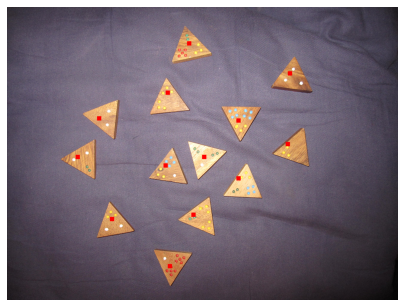

Координаты центра: 165 290
Очки             : 4; 1; 1; 

Координаты центра: 190 385
Очки             : 1; 1; 1; 

Координаты центра: 190 655
Очки             : 3; 3; 1; 

Координаты центра: 290 410
Очки             : 2; 

Координаты центра: 300 515
Очки             : 5; 5; 1; 

Координаты центра: 320 260
Очки             : 1; 1; 

Координаты центра: 360 350
Очки             : 3; 

Координаты центра: 365 600
Очки             : 3; 2; 1; 

Координаты центра: 395 500
Очки             : 3; 3; 2; 

Image shape:  (684, 912, 3)


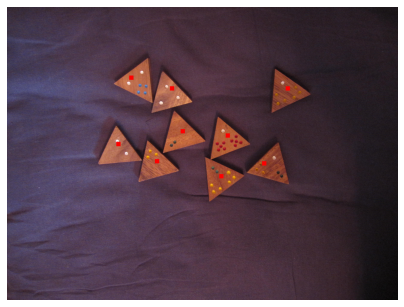

Координаты центра: 180 705
Очки             : 3; 3; 1; 

Координаты центра: 365 655
Очки             : 3; 2; 1; 

Координаты центра: 130 320
Очки             : 4; 1; 1; 

Координаты центра: 275 435
Очки             : 2; 

Координаты центра: 290 550
Очки             : 5; 5; 1; 

Координаты центра: 165 405
Очки             : 1; 1; 1; 

Координаты центра: 300 270
Очки             : 1; 1; 

Координаты центра: 390 540
Очки             : 3; 3; 2; 

Координаты центра: 345 365
Очки             : 3; 

Image shape:  (684, 912, 3)


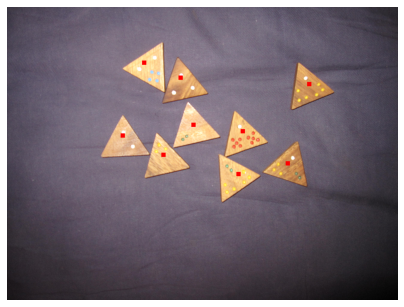

In [28]:
path_to_data = "/Users/mac/Downloads/Обучение"
main(data_path=path_to_data, img_number=2) # Программа настроена на уровень сложности Intermediate,
main(data_path=path_to_data, img_number=3) # что соответстсвует этим трём номерам изображений.
main(data_path=path_to_data, img_number=4) # 